In [1]:
from sklearn.preprocessing import FunctionTransformer

from reskit.norms import binar_norm

from reskit.core import Transformer, Pipeliner

from sklearn.feature_selection import VarianceThreshold

from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import StratifiedKFold

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

import os
import pandas as pd
import numpy as np

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

def orig(x):
    return x

import matrix_eig as me

from matplotlib import pyplot as plt
%matplotlib inline
import re

/home/mokrov/.local/lib/python2.7/site-packages/pandas/core/computation/__init__.py:18: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


In [2]:
def get_autism(path_to_read='../Data/dti/', distances=True):
    def get_autism_distances(loc_name):
        with open(loc_name, 'r') as f:
            read_data = f.readlines()

        read_data = pd.DataFrame(
            np.array([np.array(item[:-1].split()).astype(int) for item in read_data]))

        return read_data

    def get_distance_matrix(coords):
        if type(coords) == pd.core.frame.DataFrame:
            coords = coords.values
        elif type(coords) != np.ndarray:
            print('Provide either pandas df or numpy array!')
            return -1

        shape = len(coords)
        dist_matrix = np.zeros((shape, shape))
        del shape
        for i in range(len(coords)):
            for j in range(i + 1, len(coords)):
                dist_matrix[i, j] = np.linalg.norm(coords[i, :] - coords[j, :])
                dist_matrix[j, i] = dist_matrix[i, j]
        return dist_matrix

    target_vector = []  # this will be a target vector (diagnosis)
    matrices = []  # this will be a list of connectomes
    all_files = sorted(os.listdir(path_to_read))
    matrix_files = [
        item for item in all_files if 'DTI_connectivity' in item and 'All' not in item]
    distance_files = [
        item for item in all_files if 'DTI_region_xyz_centers' in item and 'All' not in item]

    # for each file in a sorted (!) list of files:
    for filename in matrix_files:

        A_dataframe = pd.read_csv(
            path_to_read + filename, sep='   ', header=None, engine='python')
        A = A_dataframe.values  # we will use a list of numpy arrays, NOT pandas dataframes
        matrices.append(A)# append a matrix to our list
        if "ASD" in filename:
            target_vector.append(1)
        elif "TD" in filename:
            target_vector.append(0)
    asd_dict = {}
    asd_dict['X'] = np.array(matrices)
    asd_dict['y'] = np.array(target_vector)
    if distances:
        dist_matrix_list = []
        for item in distance_files:
            # print(item)
            cur_coord = get_autism_distances(path_to_read + item)
            cur_dist_mtx = get_distance_matrix(cur_coord)
            dist_matrix_list += [cur_dist_mtx]

        asd_dict['dist'] = np.array(dist_matrix_list)

    return asd_dict

In [3]:
params = {
    'text.usetex'         : True,
    'text.latex.unicode'  : True,
    'text.latex.preamble' : r"\usepackage[T2A]{fontenc}",
    'font.size'           : 15,
    'font.family'         : 'lmodern'
    }

plt.rcParams.update(params)



def print_boxplot(file_name, mod, figsize = (10.5,6.5)):
    ##################################################################
    # Paramatrs:                                                     #
    #----------------------------------------------------------------#
    # file_name: string, name of file witch has a table with columns:# 
    #           'eval_roc_auc_scores' and 'Featurizers'              #
    #                                                                #
    # mod: string, additional information for boxplot                #
    #                                                                #
    # figsize: w,h tuple in inches                                   #
    ##################################################################
    data = []
    result = pd.read_csv(file_name, index_col=0)
    
    lables          = result['Featurizers']
    array_of_arrays = result['eval_roc_auc_scores']
    for tmp in array_of_arrays:
        array_str = re.split('[]*[ ,]', tmp)
        ##########################################
        #Костыль
        for i in range(array_str.count('')):
            array_str.remove('')
        ##########################################
        array_fold = []
        for i in array_str:
            array_fold.append(float(i))
        data.append(array_fold)
        
    fig = plt.figure(figsize=figsize)
    ax  = fig.add_subplot(111)
    bp  = ax.boxplot(data, 0, '+', labels=lables)
    
    plt.setp(bp['boxes'],    color='DarkGreen')
    plt.setp(bp['whiskers'], color='DarkOrange', linestyle = '-')
    plt.setp(bp['medians'],  color='DarkBlue')
    plt.setp(bp['caps'],     color='Gray')
    
    
    ax.set_title(r'ROC AUC mean for LogisticRegression (' + mod + ').' )
    ax.set_ylabel(r'ROC AUC mean')
    ax.set_xlabel(r'k')
    ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',alpha=0.5)
    
    plt.show()

## Train LogRegression and conctrsuct BoxPlot

In [4]:
grid_cv = StratifiedKFold(n_splits=10,
                          shuffle=True,
                          random_state=0)

eval_cv = StratifiedKFold(n_splits=10,
                          shuffle=True,
                          random_state=1)

In [5]:
#1

In [6]:
data = [('UCLAsource', Transformer(get_autism))]

weighters = [('orig', Transformer(orig))]

normalizers = [('origN', Transformer(orig))]

featurizers = [('Orig',   Transformer(me.orig_vec,       collect=['X_vec'])),
               ('0',      Transformer(me.matrix_eig1_0,   collect=['X_vec'])),
               ('20',     Transformer(me.matrix_eig1_20,  collect=['X_vec'])),
               ('40',     Transformer(me.matrix_eig1_40,  collect=['X_vec'])),
               ('60',     Transformer(me.matrix_eig1_60,  collect=['X_vec'])),
               ('80',     Transformer(me.matrix_eig1_80,  collect=['X_vec'])),
               ('100',    Transformer(me.matrix_eig1_100, collect=['X_vec'])),
               ('120',    Transformer(me.matrix_eig1_120, collect=['X_vec'])),
               ('140',    Transformer(me.matrix_eig1_140, collect=['X_vec'])),
               ('160',    Transformer(me.matrix_eig1_160, collect=['X_vec'])),
               ('180',    Transformer(me.matrix_eig1_180, collect=['X_vec'])),
               ('200',    Transformer(me.matrix_eig1_200, collect=['X_vec'])),
               ('220',    Transformer(me.matrix_eig1_220, collect=['X_vec'])),
               ('240',    Transformer(me.matrix_eig1_240, collect=['X_vec'])),
               ('260',    Transformer(me.matrix_eig1_260, collect=['X_vec']))]


selectors = [('var_threshold', VarianceThreshold())]

scalers = [('minmax', MinMaxScaler())]

classifiers = [('LR', LogisticRegression())]

steps = [('Data', data),
         ('Weighters', weighters),
         ('Normalizers', normalizers),
         ('Featurizers', featurizers),
         ('Selectors', selectors),
         ('Scalers', scalers),
         ('Classifiers', classifiers)]

param_grid = dict(
     LR=dict(
        C=[0.01] + [0.1*i for i in range(1, 11)],
        max_iter=[50, 100],
        penalty=['l1']
    )
    )

banned_combos = []

steps = [('Data', data),
         ('Weighters', weighters),
         ('Normalizers', normalizers),
         ('Featurizers', featurizers),
         ('Selectors', selectors),
         ('Scalers', scalers),
         ('Classifiers', classifiers)]

pipe = Pipeliner(steps, eval_cv=eval_cv, grid_cv=grid_cv, param_grid=param_grid, banned_combos=banned_combos)
pipe.plan_table

,Data,Weighters,Normalizers,Featurizers,Selectors,Scalers,Classifiers
0,UCLAsource,orig,origN,Orig,var_threshold,minmax,LR
1,UCLAsource,orig,origN,0,var_threshold,minmax,LR
2,UCLAsource,orig,origN,20,var_threshold,minmax,LR
3,UCLAsource,orig,origN,40,var_threshold,minmax,LR
4,UCLAsource,orig,origN,60,var_threshold,minmax,LR
5,UCLAsource,orig,origN,80,var_threshold,minmax,LR
6,UCLAsource,orig,origN,100,var_threshold,minmax,LR
7,UCLAsource,orig,origN,120,var_threshold,minmax,LR
8,UCLAsource,orig,origN,140,var_threshold,minmax,LR
9,UCLAsource,orig,origN,160,var_threshold,minmax,LR


In [7]:
pipe.get_results('../Data/dti/', caching_steps=['Data', 'Weighters', 'Normalizers', 'Featurizers'],
                 scoring=['roc_auc'], collect_n = 50, results_file = 'LR/orig_eig_noabs.csv')

No previous results found.
Line: 1/15
Line: 2/15
Line: 3/15
Line: 4/15
Line: 5/15
Line: 6/15
Line: 7/15
Line: 8/15
Line: 9/15
Line: 10/15
Line: 11/15
Line: 12/15
Line: 13/15
Line: 14/15
Line: 15/15


,Data,Weighters,Normalizers,Featurizers,Selectors,Scalers,Classifiers,grid_roc_auc_mean,grid_roc_auc_std,grid_roc_auc_best_params,eval_roc_auc_mean,eval_roc_auc_std,eval_roc_auc_scores
0,UCLAsource,orig,origN,Orig,var_threshold,minmax,LR,0.510638,0.0308327,"{'penalty': 'l1', 'C': 0.2, 'max_iter': 50}",0.496498,0.00629337,"[0.50250797993616059, 0.49088007295941638, 0.5..."
1,UCLAsource,orig,origN,0,var_threshold,minmax,LR,0.516489,0.175794,"{'penalty': 'l1', 'C': 0.30000000000000004, 'm...",0.491737,0.0104586,"[0.51345189238486089, 0.48039215686274511, 0.4..."
2,UCLAsource,orig,origN,20,var_threshold,minmax,LR,0.643262,0.191808,"{'penalty': 'l1', 'C': 0.5, 'max_iter': 50}",0.546493,0.0345152,"[0.59165526675786584, 0.54514363885088923, 0.5..."
3,UCLAsource,orig,origN,40,var_threshold,minmax,LR,0.633511,0.225736,"{'penalty': 'l1', 'C': 0.30000000000000004, 'm...",0.498928,0.0104196,"[0.5, 0.5, 0.51162790697674421, 0.5, 0.4803921..."
4,UCLAsource,orig,origN,60,var_threshold,minmax,LR,0.638298,0.122263,"{'penalty': 'l1', 'C': 1.0, 'max_iter': 50}",0.553739,0.0421657,"[0.55608755129958953, 0.56224350205198359, 0.5..."
5,UCLAsource,orig,origN,80,var_threshold,minmax,LR,0.631738,0.107949,"{'penalty': 'l1', 'C': 0.9, 'max_iter': 100}",0.546977,0.0467388,"[0.6105791153670771, 0.52120383036935714, 0.54..."
6,UCLAsource,orig,origN,100,var_threshold,minmax,LR,0.720745,0.152533,"{'penalty': 'l1', 'C': 0.9, 'max_iter': 100}",0.613926,0.0416257,"[0.60875512995896042, 0.59712722298221621, 0.7..."
7,UCLAsource,orig,origN,120,var_threshold,minmax,LR,0.624113,0.200732,"{'penalty': 'l1', 'C': 0.5, 'max_iter': 100}",0.571441,0.0386758,"[0.61308709530323757, 0.57569539443684459, 0.5..."
8,UCLAsource,orig,origN,140,var_threshold,minmax,LR,0.656738,0.0718515,"{'penalty': 'l1', 'C': 0.5, 'max_iter': 100}",0.571172,0.0438887,"[0.63451892384860931, 0.53898768809849529, 0.5..."
9,UCLAsource,orig,origN,160,var_threshold,minmax,LR,0.689539,0.174544,"{'penalty': 'l1', 'C': 0.9, 'max_iter': 100}",0.604523,0.0457396,"[0.6105791153670771, 0.55061559507523938, 0.59..."


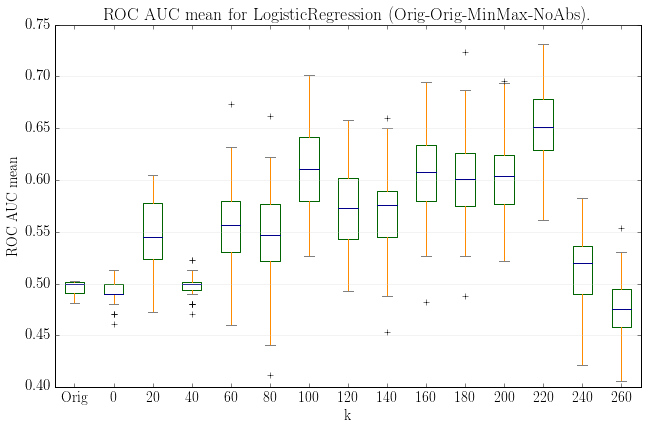

In [8]:
print_boxplot('LR/orig_eig_noabs.csv', 'Orig-Orig-MinMax-NoAbs')

In [9]:
#2

In [10]:
data = [('UCLAsource', Transformer(get_autism))]

weighters = [('orig', Transformer(orig))]

normalizers = [('origN', Transformer(orig))]

featurizers = [('Orig',   Transformer(me.orig_vec,       collect=['X_vec'])),
               ('0',      Transformer(me.matrix_eig2_0,   collect=['X_vec'])),
               ('20',     Transformer(me.matrix_eig2_20,  collect=['X_vec'])),
               ('40',     Transformer(me.matrix_eig2_40,  collect=['X_vec'])),
               ('60',     Transformer(me.matrix_eig2_60,  collect=['X_vec'])),
               ('80',     Transformer(me.matrix_eig2_80,  collect=['X_vec'])),
               ('100',    Transformer(me.matrix_eig2_100, collect=['X_vec'])),
               ('120',    Transformer(me.matrix_eig2_120, collect=['X_vec'])),
               ('140',    Transformer(me.matrix_eig2_140, collect=['X_vec'])),
               ('160',    Transformer(me.matrix_eig2_160, collect=['X_vec'])),
               ('180',    Transformer(me.matrix_eig2_180, collect=['X_vec'])),
               ('200',    Transformer(me.matrix_eig2_200, collect=['X_vec'])),
               ('220',    Transformer(me.matrix_eig2_220, collect=['X_vec'])),
               ('240',    Transformer(me.matrix_eig2_240, collect=['X_vec'])),
               ('260',    Transformer(me.matrix_eig2_260, collect=['X_vec']))]


selectors = [('var_threshold', VarianceThreshold())]

scalers = [('minmax', MinMaxScaler())]

classifiers = [('LR', LogisticRegression())]

steps = [('Data', data),
         ('Weighters', weighters),
         ('Normalizers', normalizers),
         ('Featurizers', featurizers),
         ('Selectors', selectors),
         ('Scalers', scalers),
         ('Classifiers', classifiers)]

param_grid = dict(
     LR=dict(
        C=[0.01] + [0.1*i for i in range(1, 11)],
        max_iter=[50, 100],
        penalty=['l1']
    )
    )

banned_combos = []

steps = [('Data', data),
         ('Weighters', weighters),
         ('Normalizers', normalizers),
         ('Featurizers', featurizers),
         ('Selectors', selectors),
         ('Scalers', scalers),
         ('Classifiers', classifiers)]

pipe = Pipeliner(steps, eval_cv=eval_cv, grid_cv=grid_cv, param_grid=param_grid, banned_combos=banned_combos)
pipe.plan_table

,Data,Weighters,Normalizers,Featurizers,Selectors,Scalers,Classifiers
0,UCLAsource,orig,origN,Orig,var_threshold,minmax,LR
1,UCLAsource,orig,origN,0,var_threshold,minmax,LR
2,UCLAsource,orig,origN,20,var_threshold,minmax,LR
3,UCLAsource,orig,origN,40,var_threshold,minmax,LR
4,UCLAsource,orig,origN,60,var_threshold,minmax,LR
5,UCLAsource,orig,origN,80,var_threshold,minmax,LR
6,UCLAsource,orig,origN,100,var_threshold,minmax,LR
7,UCLAsource,orig,origN,120,var_threshold,minmax,LR
8,UCLAsource,orig,origN,140,var_threshold,minmax,LR
9,UCLAsource,orig,origN,160,var_threshold,minmax,LR


In [11]:
pipe.get_results('../Data/dti/', caching_steps=['Data', 'Weighters', 'Normalizers', 'Featurizers'],
                 scoring=['roc_auc'], collect_n = 50, results_file = 'LR/orig_eig_abs.csv')

No previous results found.
Line: 1/15
Line: 2/15
Line: 3/15
Line: 4/15
Line: 5/15
Line: 6/15
Line: 7/15
Line: 8/15
Line: 9/15
Line: 10/15
Line: 11/15
Line: 12/15
Line: 13/15
Line: 14/15
Line: 15/15


,Data,Weighters,Normalizers,Featurizers,Selectors,Scalers,Classifiers,grid_roc_auc_mean,grid_roc_auc_std,grid_roc_auc_best_params,eval_roc_auc_mean,eval_roc_auc_std,eval_roc_auc_scores
0,UCLAsource,orig,origN,Orig,var_threshold,minmax,LR,0.510638,0.0308327,"{'penalty': 'l1', 'C': 0.2, 'max_iter': 50}",0.496498,0.00629337,"[0.50250797993616059, 0.49088007295941638, 0.5..."
1,UCLAsource,orig,origN,0,var_threshold,minmax,LR,0.513121,0.180298,"{'penalty': 'l1', 'C': 0.30000000000000004, 'm...",0.49181,0.0106362,"[0.51345189238486089, 0.49202006383948932, 0.4..."
2,UCLAsource,orig,origN,20,var_threshold,minmax,LR,0.5,0,"{'penalty': 'l1', 'C': 0.01, 'max_iter': 50}",0.5,0,"[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, ..."
3,UCLAsource,orig,origN,40,var_threshold,minmax,LR,0.556206,0.209401,"{'penalty': 'l1', 'C': 0.7000000000000001, 'ma...",0.46192,0.0416475,"[0.48381212950296398, 0.46671226630186957, 0.4..."
4,UCLAsource,orig,origN,60,var_threshold,minmax,LR,0.572872,0.111914,"{'penalty': 'l1', 'C': 0.4, 'max_iter': 100}",0.477843,0.0334496,"[0.49133606931144552, 0.47355221158230731, 0.4..."
5,UCLAsource,orig,origN,80,var_threshold,minmax,LR,0.77305,0.110701,"{'penalty': 'l1', 'C': 0.5, 'max_iter': 100}",0.643238,0.0356769,"[0.60510715914272684, 0.66940264477884182, 0.6..."
6,UCLAsource,orig,origN,100,var_threshold,minmax,LR,0.529787,0.0934331,"{'penalty': 'l1', 'C': 0.2, 'max_iter': 50}",0.48523,0.00707078,"[0.49179206566347478, 0.4867761057911536, 0.47..."
7,UCLAsource,orig,origN,120,var_threshold,minmax,LR,0.661702,0.0912751,"{'penalty': 'l1', 'C': 0.4, 'max_iter': 50}",0.575034,0.033322,"[0.55129958960328318, 0.55129958960328318, 0.5..."
8,UCLAsource,orig,origN,140,var_threshold,minmax,LR,0.5,0,"{'penalty': 'l1', 'C': 0.01, 'max_iter': 50}",0.5,0,"[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, ..."
9,UCLAsource,orig,origN,160,var_threshold,minmax,LR,0.510638,0.139275,"{'penalty': 'l1', 'C': 1.0, 'max_iter': 100}",0.450064,0.044635,"[0.46055631554947563, 0.47765617875057004, 0.4..."


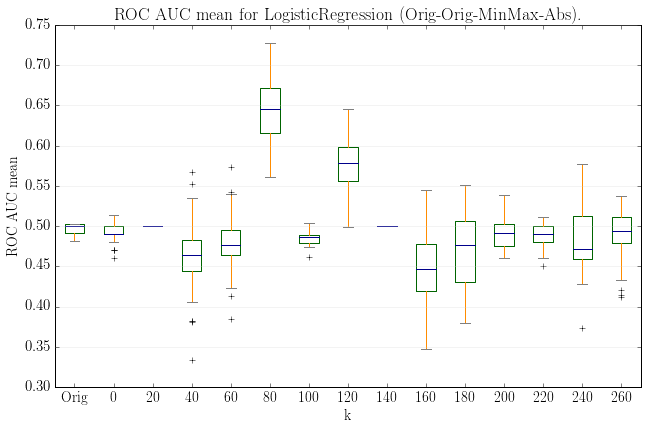

In [12]:
print_boxplot('LR/orig_eig_abs.csv', 'Orig-Orig-MinMax-Abs')

In [13]:
#3

In [14]:
data = [('UCLAsource', Transformer(get_autism))]

weighters = [('orig', Transformer(orig))]

normalizers = [('origN', Transformer(orig))]

featurizers = [('Orig',   Transformer(me.orig_vec,       collect=['X_vec'])),
               ('0',      Transformer(me.matrix_eig3_0,   collect=['X_vec'])),
               ('20',     Transformer(me.matrix_eig3_20,  collect=['X_vec'])),
               ('40',     Transformer(me.matrix_eig3_40,  collect=['X_vec'])),
               ('60',     Transformer(me.matrix_eig3_60,  collect=['X_vec'])),
               ('80',     Transformer(me.matrix_eig3_80,  collect=['X_vec'])),
               ('100',    Transformer(me.matrix_eig3_100, collect=['X_vec'])),
               ('120',    Transformer(me.matrix_eig3_120, collect=['X_vec'])),
               ('140',    Transformer(me.matrix_eig3_140, collect=['X_vec'])),
               ('160',    Transformer(me.matrix_eig3_160, collect=['X_vec'])),
               ('180',    Transformer(me.matrix_eig3_180, collect=['X_vec'])),
               ('200',    Transformer(me.matrix_eig3_200, collect=['X_vec'])),
               ('220',    Transformer(me.matrix_eig3_220, collect=['X_vec'])),
               ('240',    Transformer(me.matrix_eig3_240, collect=['X_vec'])),
               ('260',    Transformer(me.matrix_eig3_260, collect=['X_vec']))]


selectors = [('var_threshold', VarianceThreshold())]

scalers = [('minmax', MinMaxScaler())]

classifiers = [('LR', LogisticRegression())]

steps = [('Data', data),
         ('Weighters', weighters),
         ('Normalizers', normalizers),
         ('Featurizers', featurizers),
         ('Selectors', selectors),
         ('Scalers', scalers),
         ('Classifiers', classifiers)]

param_grid = dict(
     LR=dict(
        C=[0.01] + [0.1*i for i in range(1, 11)],
        max_iter=[50, 100],
        penalty=['l1']
    )
    )

banned_combos = []

steps = [('Data', data),
         ('Weighters', weighters),
         ('Normalizers', normalizers),
         ('Featurizers', featurizers),
         ('Selectors', selectors),
         ('Scalers', scalers),
         ('Classifiers', classifiers)]

pipe = Pipeliner(steps, eval_cv=eval_cv, grid_cv=grid_cv, param_grid=param_grid, banned_combos=banned_combos)
pipe.plan_table

,Data,Weighters,Normalizers,Featurizers,Selectors,Scalers,Classifiers
0,UCLAsource,orig,origN,Orig,var_threshold,minmax,LR
1,UCLAsource,orig,origN,0,var_threshold,minmax,LR
2,UCLAsource,orig,origN,20,var_threshold,minmax,LR
3,UCLAsource,orig,origN,40,var_threshold,minmax,LR
4,UCLAsource,orig,origN,60,var_threshold,minmax,LR
5,UCLAsource,orig,origN,80,var_threshold,minmax,LR
6,UCLAsource,orig,origN,100,var_threshold,minmax,LR
7,UCLAsource,orig,origN,120,var_threshold,minmax,LR
8,UCLAsource,orig,origN,140,var_threshold,minmax,LR
9,UCLAsource,orig,origN,160,var_threshold,minmax,LR


In [15]:
pipe.get_results('../Data/dti/', caching_steps=['Data', 'Weighters', 'Normalizers', 'Featurizers'],
                 scoring=['roc_auc'], collect_n = 50, results_file = 'LR/orig_eig_absabs.csv')

No previous results found.
Line: 1/15
Line: 2/15
Line: 3/15
Line: 4/15
Line: 5/15
Line: 6/15
Line: 7/15
Line: 8/15
Line: 9/15
Line: 10/15
Line: 11/15
Line: 12/15
Line: 13/15
Line: 14/15
Line: 15/15


,Data,Weighters,Normalizers,Featurizers,Selectors,Scalers,Classifiers,grid_roc_auc_mean,grid_roc_auc_std,grid_roc_auc_best_params,eval_roc_auc_mean,eval_roc_auc_std,eval_roc_auc_scores
0,UCLAsource,orig,origN,Orig,var_threshold,minmax,LR,0.510638,0.0308327,"{'penalty': 'l1', 'C': 0.2, 'max_iter': 50}",0.496498,0.00629337,"[0.50250797993616059, 0.49088007295941638, 0.5..."
1,UCLAsource,orig,origN,0,var_threshold,minmax,LR,0.5,0,"{'penalty': 'l1', 'C': 0.01, 'max_iter': 50}",0.5,0,"[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, ..."
2,UCLAsource,orig,origN,20,var_threshold,minmax,LR,0.5,0,"{'penalty': 'l1', 'C': 0.01, 'max_iter': 50}",0.5,0,"[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, ..."
3,UCLAsource,orig,origN,40,var_threshold,minmax,LR,0.52766,0.156017,"{'penalty': 'l1', 'C': 1.0, 'max_iter': 50}",0.465048,0.0493233,"[0.44277245782033747, 0.5499316005471957, 0.42..."
4,UCLAsource,orig,origN,60,var_threshold,minmax,LR,0.5,0,"{'penalty': 'l1', 'C': 0.01, 'max_iter': 50}",0.5,0,"[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, ..."
5,UCLAsource,orig,origN,80,var_threshold,minmax,LR,0.733156,0.0814574,"{'penalty': 'l1', 'C': 0.5, 'max_iter': 50}",0.632535,0.0416643,"[0.55426356589147285, 0.70246238030095753, 0.6..."
6,UCLAsource,orig,origN,100,var_threshold,minmax,LR,0.553014,0.185059,"{'penalty': 'l1', 'C': 1.0, 'max_iter': 100}",0.488691,0.0383673,"[0.41951664386684906, 0.53465572275421791, 0.4..."
7,UCLAsource,orig,origN,120,var_threshold,minmax,LR,0.65922,0.140146,"{'penalty': 'l1', 'C': 0.2, 'max_iter': 50}",0.510812,0.00520317,"[0.50911992704058373, 0.51162790697674421, 0.5..."
8,UCLAsource,orig,origN,140,var_threshold,minmax,LR,0.5,0,"{'penalty': 'l1', 'C': 0.01, 'max_iter': 50}",0.5,0,"[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, ..."
9,UCLAsource,orig,origN,160,var_threshold,minmax,LR,0.5,0,"{'penalty': 'l1', 'C': 0.01, 'max_iter': 50}",0.5,0,"[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, ..."


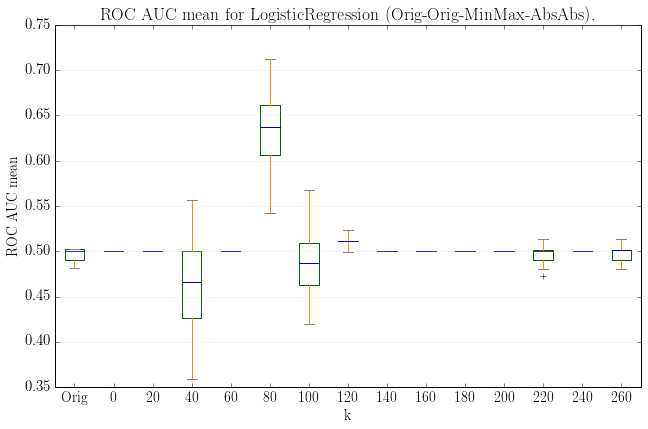

In [16]:
print_boxplot('LR/orig_eig_absabs.csv', 'Orig-Orig-MinMax-AbsAbs')

In [17]:
#4

In [18]:
data = [('UCLAsource', Transformer(get_autism))]

weighters = [('orig', Transformer(orig))]

normalizers = [('origN', Transformer(orig))]

featurizers = [('Orig',   Transformer(me.orig_vec,       collect=['X_vec'])),
               ('0',      Transformer(me.matrix_eig_0,   collect=['X_vec'])),
               ('20',     Transformer(me.matrix_eig_20,  collect=['X_vec'])),
               ('40',     Transformer(me.matrix_eig_40,  collect=['X_vec'])),
               ('60',     Transformer(me.matrix_eig_60,  collect=['X_vec'])),
               ('80',     Transformer(me.matrix_eig_80,  collect=['X_vec'])),
               ('100',    Transformer(me.matrix_eig_100, collect=['X_vec'])),
               ('120',    Transformer(me.matrix_eig_120, collect=['X_vec'])),
               ('140',    Transformer(me.matrix_eig_140, collect=['X_vec'])),
               ('160',    Transformer(me.matrix_eig_160, collect=['X_vec'])),
               ('180',    Transformer(me.matrix_eig_180, collect=['X_vec'])),
               ('200',    Transformer(me.matrix_eig_200, collect=['X_vec'])),
               ('220',    Transformer(me.matrix_eig_220, collect=['X_vec'])),
               ('240',    Transformer(me.matrix_eig_240, collect=['X_vec'])),
               ('260',    Transformer(me.matrix_eig_260, collect=['X_vec']))]


selectors = [('var_threshold', VarianceThreshold())]

scalers = [('minmax', MinMaxScaler())]

classifiers = [('LR', LogisticRegression())]

steps = [('Data', data),
         ('Weighters', weighters),
         ('Normalizers', normalizers),
         ('Featurizers', featurizers),
         ('Selectors', selectors),
         ('Scalers', scalers),
         ('Classifiers', classifiers)]

param_grid = dict(
     LR=dict(
        C=[0.01] + [0.1*i for i in range(1, 11)],
        max_iter=[50, 100],
        penalty=['l1']
    )
    )

banned_combos = []

steps = [('Data', data),
         ('Weighters', weighters),
         ('Normalizers', normalizers),
         ('Featurizers', featurizers),
         ('Selectors', selectors),
         ('Scalers', scalers),
         ('Classifiers', classifiers)]

pipe = Pipeliner(steps, eval_cv=eval_cv, grid_cv=grid_cv, param_grid=param_grid, banned_combos=banned_combos)
pipe.plan_table

,Data,Weighters,Normalizers,Featurizers,Selectors,Scalers,Classifiers
0,UCLAsource,orig,origN,Orig,var_threshold,minmax,LR
1,UCLAsource,orig,origN,0,var_threshold,minmax,LR
2,UCLAsource,orig,origN,20,var_threshold,minmax,LR
3,UCLAsource,orig,origN,40,var_threshold,minmax,LR
4,UCLAsource,orig,origN,60,var_threshold,minmax,LR
5,UCLAsource,orig,origN,80,var_threshold,minmax,LR
6,UCLAsource,orig,origN,100,var_threshold,minmax,LR
7,UCLAsource,orig,origN,120,var_threshold,minmax,LR
8,UCLAsource,orig,origN,140,var_threshold,minmax,LR
9,UCLAsource,orig,origN,160,var_threshold,minmax,LR


In [19]:
pipe.get_results('../Data/dti/', caching_steps=['Data', 'Weighters', 'Normalizers', 'Featurizers'],
                 scoring=['roc_auc'], collect_n = 50, results_file = 'LR/orig_eig_absrand.csv')

No previous results found.
Line: 1/15
Line: 2/15
Line: 3/15
Line: 4/15
Line: 5/15
Line: 6/15
Line: 7/15
Line: 8/15
Line: 9/15
Line: 10/15
Line: 11/15
Line: 12/15
Line: 13/15
Line: 14/15
Line: 15/15


,Data,Weighters,Normalizers,Featurizers,Selectors,Scalers,Classifiers,grid_roc_auc_mean,grid_roc_auc_std,grid_roc_auc_best_params,eval_roc_auc_mean,eval_roc_auc_std,eval_roc_auc_scores
0,UCLAsource,orig,origN,Orig,var_threshold,minmax,LR,0.510638,0.0308327,"{'penalty': 'l1', 'C': 0.2, 'max_iter': 50}",0.496498,0.00629337,"[0.50250797993616059, 0.49088007295941638, 0.5..."
1,UCLAsource,orig,origN,0,var_threshold,minmax,LR,0.5,0,"{'penalty': 'l1', 'C': 0.01, 'max_iter': 50}",0.5,0,"[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, ..."
2,UCLAsource,orig,origN,20,var_threshold,minmax,LR,0.623759,0.177097,"{'penalty': 'l1', 'C': 0.9, 'max_iter': 50}",0.513967,0.0362702,"[0.52485180118559049, 0.47469220246238031, 0.5..."
3,UCLAsource,orig,origN,40,var_threshold,minmax,LR,0.648936,0.151021,"{'penalty': 'l1', 'C': 0.30000000000000004, 'm...",0.492791,0.00854758,"[0.49019607843137253, 0.48039215686274511, 0.5..."
4,UCLAsource,orig,origN,60,var_threshold,minmax,LR,0.65656,0.144779,"{'penalty': 'l1', 'C': 1.0, 'max_iter': 100}",0.574665,0.0415082,"[0.63201094391244883, 0.60693114455084363, 0.6..."
5,UCLAsource,orig,origN,80,var_threshold,minmax,LR,0.59734,0.152979,"{'penalty': 'l1', 'C': 0.30000000000000004, 'm...",0.497802,0.0102044,"[0.5, 0.49202006383948932, 0.51345189238486089..."
6,UCLAsource,orig,origN,100,var_threshold,minmax,LR,0.566135,0.204556,"{'penalty': 'l1', 'C': 0.30000000000000004, 'm...",0.502959,0.00739958,"[0.51162790697674421, 0.5, 0.52325581395348841..."
7,UCLAsource,orig,origN,120,var_threshold,minmax,LR,0.523936,0.066336,"{'penalty': 'l1', 'C': 0.30000000000000004, 'm...",0.492517,0.011897,"[0.50364797081623347, 0.49019607843137253, 0.4..."
8,UCLAsource,orig,origN,140,var_threshold,minmax,LR,0.608688,0.173224,"{'penalty': 'l1', 'C': 0.2, 'max_iter': 50}",0.504036,0.0107942,"[0.52325581395348841, 0.51162790697674421, 0.5..."
9,UCLAsource,orig,origN,160,var_threshold,minmax,LR,0.5,0,"{'penalty': 'l1', 'C': 0.01, 'max_iter': 50}",0.5,0,"[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, ..."


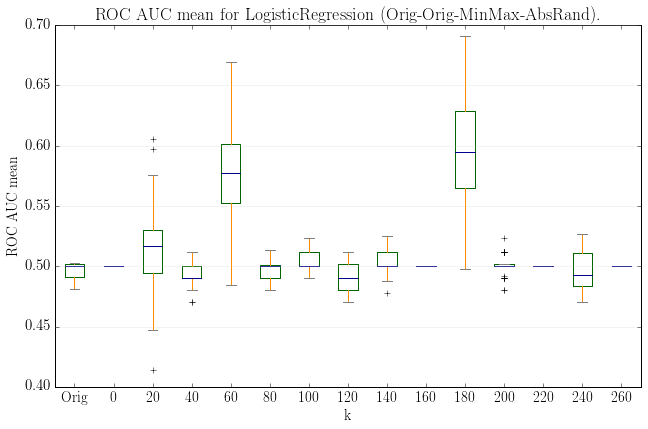

In [20]:
print_boxplot('LR/orig_eig_absrand.csv', 'Orig-Orig-MinMax-AbsRand')